# Web scraping of .cif files

Goal: to get .cif files of a material in each space group from the TQC.org database.

## Method 2: scrap Materials Project

In [1]:
from mp_api.client import MPRester
import pyfplo.fedit as fedit
import pyfplo.fploio as fploio
import os
import shutil

/home/mi2/envs/venv_fplo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
API_KEY = '7hwV32FqdTRd4JKCJn2qI30qDzYvLukG'  # log in to MP and look for it there
mpr = MPRester(API_KEY)

Let's retrieve the smallest number of sites for materials in each space group (interrupted, takes quite long...)

In [3]:
def num_materials_sg(num_sg):
    '''
    Number of materials found in the MP database for a SG
    '''
    materials = mpr.materials.summary.search(spacegroup_number=num_sg,
                                             num_magnetic_sites=0,
                                             theoretical=True)
    print(f'SG {num_sg}: {len(materials)} materials')

In [4]:
list_nsites = []
for num_sg in list_failed + list_wrong_sg:
    list_nsites_local = []
    materials = mpr.materials.summary.search(spacegroup_number=num_sg, num_magnetic_sites=0)
    for mat in materials:
        list_nsites_local.append(mat.nsites)
    list_nsites.append(min(list_nsites_local))
print(f'The largest nsites found: {min(list_nsites)}')

NameError: name 'list_failed' is not defined

In [4]:
def pick_materials(list_sg=None, ind_material=0):
    if list_sg is None:
        list_sg = [i for i in range(1,231)]
    for num_sg in list_sg:
        print(f'SG {num_sg:3d}')
        materials = mpr.materials.summary.search(spacegroup_number=num_sg,
                                                 num_magnetic_sites=0,
                                                 theoretical=True)
        if len(materials) == 0:
            print(f'SG {num_sg}: no material found.')
        try:
            id = materials[ind_material].material_id
        except IndexError:
            print('No material found')
            continue
        cif = mpr.get_structure_by_material_id(id).to(fmt="cif")
        with open(f'{num_sg}.cif', 'w') as f:
            f.write(cif)

Import CIF file and create a =.in with its crytal structure

In [5]:
def printsettings(onlygroup=True):
    fio=fploio.FPLOInput('=.in')
    par=fio.parser()
    d=par()
    if not onlygroup:
        print( 'spacegroup setting: ',d('spacegroup.setting').S)
        print( 'lattice constants : ',d('lattice_constants').listS)
        print( 'axis angle        : ',d('axis_angles').listS)
        dw=d('wyckoff_positions')
        print( 'Wyckoff positions: ',dw.size())
        for i in range(dw.size()):
            taus=dw[i]('tau').listS
            print( '{0:>2s} {1:>20s} {2:>20s} {3:>20s}'.format(dw[i]('element').S,taus[0],taus[1],taus[2]))
    return int(d('spacegroup.number').S)

In [6]:
def convert_cifs_to_ins(list_sg=None):

    tol_wp = 1e-4
    
    list_failed = []
    list_wrong_sg = []

    if list_sg is None:
        list_sg = [i for i in range(1, 231)]
    
    for num_sg in list_sg:
    
        print(f'Nominal sg: {num_sg}')
        if num_sg == 168 or num_sg == 207: continue  # no material in MP for 168 :S
        
        try:
    
            # Create =.in if it doesn't exits, parse cif and write into =.in
            fio=fploio.FPLOInput('=.in')
            fio.structureFromCIFFile(f'{num_sg}.cif', wyckofftolerance=tol_wp, determinesymmetry=True)
            fio.writeFile("=.in")
                
            # Change other parameters in =.in
            fed=fedit.Fedit(recreate=False)
            fed.iteration(n=100)
            fed.relativistic('s')  # no SOC
            fed.vxc('5')
            fed.pipeFedit()
            
            # Print info about crystal
            num = printsettings()
            if num != num_sg:
                list_wrong_sg.append(num_sg)
            
            
            # Create sg_ directory and move =.in into it
            in_file = '=.in'
            dir = f'sg_{num_sg}'
            
            if not os.path.exists(dir):
                os.makedirs(dir)
            
            if os.path.exists(in_file):
                destination = os.path.join(dir, os.path.basename(in_file))
                shutil.move(in_file, destination)
            else:
                print('=.in file does not exist')

        except:
            list_failed.append(num_sg)

    return list_failed, list_wrong_sg

In [11]:
def parse_sg_in(root="."):
    fio=fploio.FPLOInput(root+'=.in')
    par=fio.parser()
    d=par()
    return int(d('spacegroup.number').S)

In [26]:
for i in range(1, 231):
    sg_in = parse_sg_in(root=f'sg_{i}/')
    if sg_in != i:
        print(f'SG {i}: {sg_in == i}')

SG 168: False
SG 207: False


In [12]:
pick_materials(ind_material=0)

SG   1


/home/mi2/envs/venv_fplo/lib/python3.10/site-packages/mp_api/client/core/client.py:841: UserWarning: Use the 'fields' argument to select only fields of interest to speed up data retrieval for large queries. Choose from: ['builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'property_name', 'material_id', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas', 'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'es_source_calc_id', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_norm

SG   2


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8793.09it/s]


SG   3


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8905.10it/s]


SG   4


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7570.95it/s]


SG   5


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8719.97it/s]


SG   6


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8525.01it/s]


SG   7


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4002.20it/s]


SG   8


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9058.97it/s]


SG   9


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8473.34it/s]


SG  10


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9446.63it/s]


SG  11


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5729.92it/s]


SG  12


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4198.50it/s]


SG  13


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8507.72it/s]


SG  14


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17403.75it/s]


SG  15


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16008.79it/s]


SG  16


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8738.13it/s]


SG  17


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8081.51it/s]


SG  18


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5336.26it/s]


SG  19


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8035.07it/s]


SG  20


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9039.45it/s]


SG  21


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8289.14it/s]


SG  22


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6553.60it/s]


SG  23


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6921.29it/s]


SG  24


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8848.74it/s]


SG  25


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7108.99it/s]


SG  26


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 13573.80it/s]


SG  27


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7358.43it/s]


SG  28


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 12228.29it/s]


SG  29


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 1634.57it/s]


SG  30


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9020.01it/s]


SG  31


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4346.43it/s]


SG  32


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]


SG  33


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9000.65it/s]


SG  34


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6944.21it/s]


SG  35


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8322.03it/s]


SG  36


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7133.17it/s]


SG  37


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 12018.06it/s]


SG  38


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 13189.64it/s]


SG  39


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8848.74it/s]


SG  40


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8322.03it/s]


SG  41


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 10894.30it/s]


SG  42


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15592.21it/s]


SG  43


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5275.85it/s]


SG  44


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 10034.22it/s]


SG  45


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8338.58it/s]


SG  46


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 12520.31it/s]


SG  47


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 10010.27it/s]


SG  48


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6754.11it/s]


SG  49


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 11650.84it/s]


SG  50


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6307.22it/s]


SG  51


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8525.01it/s]


SG  52


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7530.17it/s]


SG  53


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5426.01it/s]


SG  54


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 12157.40it/s]


SG  55


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4987.28it/s]


SG  56


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7489.83it/s]


SG  57


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7973.96it/s]


SG  58


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7695.97it/s]


SG  59


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8943.08it/s]


SG  60


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8738.13it/s]


SG  61


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 13486.51it/s]


SG  62


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 11683.30it/s]


SG  63


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8240.28it/s]


SG  64


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6052.39it/s]


SG  65


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9098.27it/s]


SG  66


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 3477.86it/s]


SG  67


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7767.23it/s]


SG  68


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7667.83it/s]


SG  69


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5322.72it/s]


SG  70


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16008.79it/s]


SG  71


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 12557.80it/s]


SG  72


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6223.00it/s]


SG  73


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4583.94it/s]


SG  74


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 13573.80it/s]


SG  75


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7913.78it/s]


SG  76


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7449.92it/s]


SG  77


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 20360.70it/s]


SG  78


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7013.89it/s]


SG  79


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8371.86it/s]


SG  80


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7345.54it/s]


SG  81


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8962.19it/s]


SG  82


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7084.97it/s]


SG  83


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16384.00it/s]


SG  84


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4315.13it/s]


SG  85


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 10591.68it/s]


SG  86


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7854.50it/s]


SG  87


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7157.52it/s]


SG  88


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 11155.06it/s]


SG  89


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8405.42it/s]


SG  90


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 11650.84it/s]


SG  91


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16320.25it/s]


SG  92


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6141.00it/s]


SG  93


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 11066.77it/s]


SG  94


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9425.40it/s]


SG  95


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 10305.42it/s]


SG  96


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7710.12it/s]


SG  97


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6132.02it/s]


SG  98


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9118.05it/s]


SG  99


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7839.82it/s]


SG 100


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8050.49it/s]


SG 101


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16256.99it/s]


SG 102


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7397.36it/s]


SG 103


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4369.07it/s]


SG 104


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4871.43it/s]


SG 105


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 13530.01it/s]


SG 106


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8338.58it/s]


SG 107


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6034.97it/s]


SG 108


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8811.56it/s]


SG 109


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7049.25it/s]


SG 110


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8192.00it/s]


SG 111


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6345.39it/s]


SG 112


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 10618.49it/s]


SG 113


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8848.74it/s]


SG 114


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7810.62it/s]


SG 115


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 12228.29it/s]


SG 116


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8630.26it/s]


SG 117


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8774.69it/s]


SG 118


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 12192.74it/s]


SG 119


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4702.13it/s]


SG 120


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4198.50it/s]


SG 121


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7781.64it/s]


SG 122


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7710.12it/s]


SG 123


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8388.61it/s]


SG 124


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9198.04it/s]


SG 125


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17050.02it/s]


SG 126


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7884.03it/s]


SG 127


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4755.45it/s]


SG 128


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8648.05it/s]


SG 129


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9279.43it/s]


SG 130


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8981.38it/s]


SG 131


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7973.96it/s]


SG 132


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8473.34it/s]


SG 133


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 3363.52it/s]


SG 134


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 3437.95it/s]


SG 135


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9279.43it/s]


SG 136


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7973.96it/s]


SG 137


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 13315.25it/s]


SG 138


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 11949.58it/s]


SG 139


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6864.65it/s]


SG 140


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6754.11it/s]


SG 141


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7145.32it/s]


SG 142


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8648.05it/s]


SG 143


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7667.83it/s]


SG 144


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4253.86it/s]


SG 145


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7476.48it/s]


SG 146


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7157.52it/s]


SG 147


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7489.83it/s]


SG 148


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8240.28it/s]


SG 149


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7598.38it/s]


SG 150


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 10131.17it/s]


SG 151


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7884.03it/s]


SG 152


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8388.61it/s]


SG 153


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8355.19it/s]


SG 154


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 1698.10it/s]


SG 155


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7973.96it/s]


SG 156


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6932.73it/s]


SG 157


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5570.12it/s]


SG 158


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6307.22it/s]


SG 159


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 2102.41it/s]


SG 160


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8371.86it/s]


SG 161


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6721.64it/s]


SG 162


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14979.66it/s]


SG 163


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 3956.89it/s]


SG 164


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17260.51it/s]


SG 165


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5017.11it/s]


SG 166


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5133.79it/s]


SG 167


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8756.38it/s]


SG 168


Retrieving SummaryDoc documents: 0it [00:00, ?it/s]


SG 168: no material found.
No material found
SG 169


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8388.61it/s]


SG 170


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4052.47it/s]


SG 171


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5023.12it/s]


SG 172


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8019.70it/s]


SG 173


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8701.88it/s]


SG 174


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7436.71it/s]


SG 175


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8240.28it/s]


SG 176


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7854.50it/s]


SG 177


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 11305.40it/s]


SG 178


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6909.89it/s]


SG 179


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7133.17it/s]


SG 180


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5035.18it/s]


SG 181


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6594.82it/s]


SG 182


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7898.88it/s]


SG 183


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8701.88it/s]


SG 184


Retrieving SummaryDoc documents: 0it [00:00, ?it/s]


SG 184: no material found.
No material found
SG 185


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7530.17it/s]


SG 186


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 3754.97it/s]


SG 187


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6307.22it/s]


SG 188


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 10155.70it/s]


SG 189


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 3594.09it/s]


SG 190


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6754.11it/s]


SG 191


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9962.72it/s]


SG 192


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6213.78it/s]


SG 193


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4052.47it/s]


SG 194


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8192.00it/s]


SG 195


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8665.92it/s]


SG 196


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5343.06it/s]


SG 197


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16844.59it/s]


SG 198


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8240.28it/s]


SG 199


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6842.26it/s]


SG 200


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7307.15it/s]


SG 201


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7371.36it/s]


SG 202


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4871.43it/s]


SG 203


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5269.23it/s]


SG 204


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6132.02it/s]


SG 205


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6123.07it/s]


SG 206


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6000.43it/s]


SG 207


Retrieving SummaryDoc documents: 0it [00:00, ?it/s]


SG 207: no material found.
No material found
SG 208


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6743.25it/s]


SG 209


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7667.83it/s]


SG 210


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5071.71it/s]


SG 211


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9709.04it/s]


SG 212


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14027.77it/s]


SG 213


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 22429.43it/s]


SG 214


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8256.50it/s]


SG 215


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9039.45it/s]


SG 216


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5391.14it/s]


SG 217


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16384.00it/s]


SG 218


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 13706.88it/s]


SG 219


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8388.61it/s]


SG 220


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8289.14it/s]


SG 221


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8756.38it/s]


SG 222


Retrieving SummaryDoc documents: 0it [00:00, ?it/s]


SG 222: no material found.
No material found
SG 223


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 3075.00it/s]


SG 224


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8305.55it/s]


SG 225


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 12905.55it/s]


SG 226


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8594.89it/s]


SG 227


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7681.88it/s]


SG 228


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7695.97it/s]


SG 229


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 10485.76it/s]


SG 230


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6710.89it/s]


In [13]:
list_failed, list_wrong_sg = convert_cifs_to_ins()

Nominal sg: 1
fedit pipe succesfull
Nominal sg: 2
fedit pipe succesfull
Nominal sg: 3
fedit pipe succesfull
Nominal sg: 4
fedit pipe succesfull
Nominal sg: 5
CPU TIME Wyckoffs::findWyckoffPositions:  0.06 sec 

------------------------------------------------------------------------
Blocks contained in cif file '1.cif':
------------------------------------------------------------------------
symmetry block No.   name
------------------------------------------------------------------------
     0               ag13(pbo3)6
------------------------------------------------------------------------
blockswithsymdata [0 ] 

Symmetry information for datablock: ag13(pbo3)6
Space group number: 1
Name-Hall         : not found
xyz-symbol        :  gives hallsymbol P 1

The following symmetry options are available:
  0 'xyz-symbols'

Getting structure from symmetry option: 'xyz-symbols'


CPU TIME determineSiteOperations:  0.00 sec 
CPU TIME analyseGroup:  0.00 sec 

 Lattice type or lattice consta

In [14]:
list_failed

[66, 139, 142, 151, 163, 181, 186, 191, 193]

In [15]:
list_wrong_sg

[4,
 11,
 13,
 15,
 18,
 21,
 23,
 24,
 33,
 34,
 37,
 45,
 46,
 56,
 58,
 59,
 61,
 64,
 67,
 70,
 72,
 73,
 74,
 76,
 79,
 84,
 87,
 93,
 94,
 95,
 97,
 109,
 110,
 120,
 121,
 122,
 129,
 131,
 134,
 140,
 143,
 144,
 145,
 147,
 149,
 153,
 154,
 157,
 158,
 159,
 166,
 167,
 169,
 170,
 171,
 172,
 173,
 175,
 176,
 178,
 179,
 180,
 182,
 185,
 188,
 189,
 196,
 203,
 206,
 213,
 214,
 230]

Let's download of other materials in the SGs that failed. Change index until list_failed is empty

In [16]:
list_failed = [list_failed]
list_wrong_sg = [list_wrong_sg]

In [28]:
for i in range(1, 20):
    pick_materials(list_sg=list_failed[-1]+list_wrong_sg[-1], ind_material=i)
    failed, wrong_sg = convert_cifs_to_ins(list_sg=list_failed[-1]+list_wrong_sg[-1])
    list_failed.append(failed)
    list_wrong_sg.append(wrong_sg)

SG  79


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8774.69it/s]


SG 181


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8097.11it/s]


SG  45


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9157.87it/s]


SG  93


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8630.26it/s]


No material found
SG 110


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 44098.99it/s]


No material found
SG 120


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 81530.75it/s]


No material found
SG 143


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5675.65it/s]


SG 144


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8774.69it/s]


SG 145


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 13934.56it/s]


SG 158


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]


SG 169


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 10810.06it/s]


SG 170


Retrieving SummaryDoc documents: 100%|██████████| 10/10 [00:00<00:00, 95108.93it/s]


No material found
SG 171


Retrieving SummaryDoc documents: 100%|██████████| 3/3 [00:00<00:00, 14106.40it/s]


No material found
SG 172


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8905.10it/s]


No material found
SG 179


Retrieving SummaryDoc documents: 100%|██████████| 2/2 [00:00<00:00, 15391.94it/s]


No material found
SG 196


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 12710.01it/s]


No material found
SG 203


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9279.43it/s]


Nominal sg: 79
fedit pipe succesfull
tions are available:
  0 'xyz-symbols'

Getting structure from symmetry option: 'xyz-symbols'


CPU TIME determineSiteOperations:  0.00 sec 
0 b 
CPU TIME analyseGroup:  0.00 sec 

 Lattice type or lattice constants changed!
 Will take default values for bandplot special symmetry points!
 number of Wyckoff positions changed!
 Will take default concentrations and initial_spin_split!


------------------------------------------------------------------------
Blocks contained in cif file '179.cif':
------------------------------------------------------------------------
symmetry block No.   name
------------------------------------------------------------------------
     0               sio2
------------------------------------------------------------------------
blockswithsymdata [0 ] 

Symmetry information for datablock: sio2
Space group number: 1
Name-Hall         : not found
xyz-symbol        :  gives hallsymbol P 1

The following symmetry options 

Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]


SG  79


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7943.76it/s]


SG  45


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7476.48it/s]


SG  93


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7781.64it/s]


No material found
SG 110


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 160632.92it/s]


No material found
SG 120


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 81180.08it/s]


No material found
SG 143


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6250.83it/s]


SG 144


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7281.78it/s]


SG 145


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 13662.23it/s]


SG 158


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8867.45it/s]


SG 169


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8719.97it/s]


SG 170


Retrieving SummaryDoc documents: 100%|██████████| 10/10 [00:00<00:00, 128266.18it/s]


No material found
SG 171


Retrieving SummaryDoc documents: 100%|██████████| 3/3 [00:00<00:00, 26434.69it/s]


No material found
SG 172


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9078.58it/s]


No material found
SG 179


Retrieving SummaryDoc documents: 100%|██████████| 2/2 [00:00<00:00, 18517.90it/s]


No material found
SG 196


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5210.32it/s]


No material found
SG 203


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7013.89it/s]


Nominal sg: 181
)2
Space group number: 1
Name-Hall         : not found
xyz-symbol        :  gives hallsymbol P 1

The following symmetry options are available:
  0 'xyz-symbols'

Getting structure from symmetry option: 'xyz-symbols'


CPU TIME determineSiteOperations:  0.00 sec 
0 b 
CPU TIME analyseGroup:  0.00 sec 

 Lattice type or lattice constants changed!
 Will take default values for bandplot special symmetry points!
 number of Wyckoff positions changed!
 Will take default concentrations and initial_spin_split!


------------------------------------------------------------------------
Blocks contained in cif file '179.cif':
------------------------------------------------------------------------
symmetry block No.   name
------------------------------------------------------------------------
     0               sio2
------------------------------------------------------------------------
blockswithsymdata [0 ] 

Symmetry information for datablock: sio2
Space group number: 1
fe

Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 11184.81it/s]


SG  79


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4568.96it/s]


SG  45


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6668.21it/s]


SG  93


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6700.17it/s]


No material found
SG 110


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 68015.74it/s]


No material found
SG 120


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 63124.98it/s]


No material found
SG 143


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9218.25it/s]


SG 144


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4519.72it/s]


SG 145


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7206.71it/s]


SG 158


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6932.73it/s]


SG 169


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6563.86it/s]


SG 170


Retrieving SummaryDoc documents: 100%|██████████| 10/10 [00:00<00:00, 63262.50it/s]


No material found
SG 171


Retrieving SummaryDoc documents: 100%|██████████| 3/3 [00:00<00:00, 24338.32it/s]


No material found
SG 172


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9510.89it/s]


No material found
SG 179


Retrieving SummaryDoc documents: 100%|██████████| 2/2 [00:00<00:00, 23045.63it/s]


No material found
SG 196


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9177.91it/s]


No material found
SG 203


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6978.88it/s]


Nominal sg: 181
-------------------------------
symmetry block No.   name
------------------------------------------------------------------------
     0               kcand(po4)2
------------------------------------------------------------------------
blockswithsymdata [0 ] 

Symmetry information for datablock: kcand(po4)2
Space group number: 1
Name-Hall         : not found
xyz-symbol        :  gives hallsymbol P 1

The following symmetry options are available:
  0 'xyz-symbols'

Getting structure from symmetry option: 'xyz-symbols'


CPU TIME determineSiteOperations:  0.00 sec 
0 b 
CPU TIME analyseGroup:  0.00 sec 

 Lattice type or lattice constants changed!
 Will take default values for bandplot special symmetry points!
 number of Wyckoff positions changed!
 Will take default concentrations and initial_spin_split!


------------------------------------------------------------------------
Blocks contained in cif file '179.cif':
----------------------------------------------------fe

Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 10485.76it/s]


SG  79


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 13706.88it/s]


SG  45


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 13662.23it/s]


SG  93


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17050.02it/s]


No material found
SG 110


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 153450.15it/s]


No material found
SG 120


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 84260.57it/s]


No material found
SG 143


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6864.65it/s]


SG 144


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6345.39it/s]


SG 145


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14513.16it/s]


SG 158


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8272.79it/s]


SG 169


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5753.50it/s]


SG 170


Retrieving SummaryDoc documents: 100%|██████████| 10/10 [00:00<00:00, 88674.50it/s]


No material found
SG 171


Retrieving SummaryDoc documents: 100%|██████████| 3/3 [00:00<00:00, 48960.75it/s]


No material found
SG 172


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16194.22it/s]


No material found
SG 179


Retrieving SummaryDoc documents: 100%|██████████| 2/2 [00:00<00:00, 23237.14it/s]


No material found
SG 196


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9198.04it/s]


No material found
SG 203


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6754.11it/s]


Nominal sg: 181
Nominal sg: 79
ke default values for bandplot special symmetry points!
 number of Wyckoff positions changed!
 Will take default concentrations and initial_spin_split!


------------------------------------------------------------------------
Blocks contained in cif file '172.cif':
------------------------------------------------------------------------
symmetry block No.   name
------------------------------------------------------------------------
     0               kcand(po4)2
------------------------------------------------------------------------
blockswithsymdata [0 ] 

Symmetry information for datablock: kcand(po4)2
Space group number: 1
Name-Hall         : not found
xyz-symbol        :  gives hallsymbol P 1

The following symmetry options are available:
  0 'xyz-symbols'

Getting structure from symmetry option: 'xyz-symbols'


CPU TIME determineSiteOperations:  0.00 sec 
0 b 
CPU TIME analyseGroup:  0.00 sec 

 Lattice type or lattice constants changed!
 Will 

Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6932.73it/s]


SG  79


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8456.26it/s]


SG  45


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7294.44it/s]


SG  93


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7825.19it/s]


No material found
SG 110


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 77672.30it/s]


No material found
SG 120


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 53317.42it/s]


No material found
SG 143


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8507.72it/s]


SG 144


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 3916.25it/s]


SG 145


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4894.17it/s]


SG 158


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7244.05it/s]


SG 169


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]


SG 170


Retrieving SummaryDoc documents: 100%|██████████| 10/10 [00:00<00:00, 160701.30it/s]


No material found
SG 171


Retrieving SummaryDoc documents: 100%|██████████| 3/3 [00:00<00:00, 25944.15it/s]


No material found
SG 172


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8355.19it/s]


No material found
SG 179


Retrieving SummaryDoc documents: 100%|██████████| 2/2 [00:00<00:00, 16320.25it/s]


No material found
SG 196


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9058.97it/s]


No material found
SG 203


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7397.36it/s]


Nominal sg: 181
fedit pipe succesfull
Nominal sg: 79
fedit pipe succesfull
Nominal sg: 45
fedit pipe succesfull
Nominal sg: 93
fedit pipe succesfull na6b4sb2po16
------------------------------------------------------------------------
blockswithsymdata [0 ] 

Symmetry information for datablock: na6b4sb2po16
Space group number: 1
Name-Hall         : not found
xyz-symbol        :  gives hallsymbol P 1

The following symmetry options are available:
  0 'xyz-symbols'

Getting structure from symmetry option: 'xyz-symbols'


CPU TIME determineSiteOperations:  0.00 sec 
CPU TIME analyseGroup:  0.00 sec 

 Lattice type or lattice constants changed!
 Will take default values for bandplot special symmetry points!
 number of Wyckoff positions changed!
 Will take default concentrations and initial_spin_split!


------------------------------------------------------------------------
Blocks contained in cif file '181.cif':
------------------------------------------------------------------------
sym

Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9020.01it/s]


SG  79


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4993.22it/s]


SG  45


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5419.00it/s]


SG  93


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 10433.59it/s]


No material found
SG 110


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 100932.45it/s]


No material found
SG 120


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 65879.12it/s]


No material found
SG 143


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5329.48it/s]


SG 144


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9198.04it/s]


SG 145


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6689.48it/s]


SG 158


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6978.88it/s]


SG 169


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5940.94it/s]


SG 170


Retrieving SummaryDoc documents: 100%|██████████| 10/10 [00:00<00:00, 106725.29it/s]


No material found
SG 171


Retrieving SummaryDoc documents: 100%|██████████| 3/3 [00:00<00:00, 21472.55it/s]


No material found
SG 172


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8439.24it/s]


No material found
SG 179


Retrieving SummaryDoc documents: 100%|██████████| 2/2 [00:00<00:00, 16878.49it/s]


No material found
SG 196


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14665.40it/s]


No material found
SG 203


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 3622.02it/s]


Nominal sg: 181
Nominal sg: 79
fedit pipe succesfull
Nominal sg: 45
fedit pipe succesfull
Nominal sg: 93
-----------------------------------------------------------------
Blocks contained in cif file '203.cif':
------------------------------------------------------------------------
symmetry block No.   name
------------------------------------------------------------------------
     0               na6b4sb2so16
------------------------------------------------------------------------
blockswithsymdata [0 ] 

Symmetry information for datablock: na6b4sb2so16
Space group number: 1
Name-Hall         : not found
xyz-symbol        :  gives hallsymbol P 1

The following symmetry options are available:
  0 'xyz-symbols'

Getting structure from symmetry option: 'xyz-symbols'


CPU TIME determineSiteOperations:  0.00 sec 
CPU TIME analyseGroup:  0.00 sec 

 Lattice type or lattice constants changed!
 Will take default values for bandplot special symmetry points!
 number of Wyckoff positions cha

Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7002.18it/s]


SG  79


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 12595.51it/s]


SG  45


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6364.65it/s]


SG  93


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8683.86it/s]


No material found
SG 110


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 132451.71it/s]


No material found
SG 120


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 94371.84it/s]


No material found
SG 143


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6069.90it/s]


SG 144


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14513.16it/s]


SG 145


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7145.32it/s]


SG 158


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7463.17it/s]


SG 169


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 3711.77it/s]


SG 170


Retrieving SummaryDoc documents: 100%|██████████| 10/10 [00:00<00:00, 159479.24it/s]


No material found
SG 171


Retrieving SummaryDoc documents: 100%|██████████| 3/3 [00:00<00:00, 20867.18it/s]


No material found
SG 172


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6775.94it/s]


No material found
SG 179


Retrieving SummaryDoc documents: 100%|██████████| 2/2 [00:00<00:00, 14315.03it/s]


No material found
SG 196


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 13189.64it/s]


No material found
SG 203


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 10381.94it/s]


Nominal sg: 181
fedit pipe succesfull
Nominal sg: 79
fedit pipe succesfull
Nominal sg: 45
fedit pipe succesfull
Nominal sg: 93
hanged!
 Will take default concentrations and initial_spin_split!


------------------------------------------------------------------------
Blocks contained in cif file '203.cif':
------------------------------------------------------------------------
symmetry block No.   name
------------------------------------------------------------------------
     0               na6bi2as(co4)4
------------------------------------------------------------------------
blockswithsymdata [0 ] 

Symmetry information for datablock: na6bi2as(co4)4
Space group number: 1
Name-Hall         : not found
xyz-symbol        :  gives hallsymbol P 1

The following symmetry options are available:
  0 'xyz-symbols'

Getting structure from symmetry option: 'xyz-symbols'


CPU TIME determineSiteOperations:  0.00 sec 
CPU TIME analyseGroup:  0.00 sec 

 Lattice type or lattice constants chan

Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14315.03it/s]


SG  79


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 12985.46it/s]


SG  45


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 11366.68it/s]


SG  93


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7796.10it/s]


No material found
SG 110


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 81884.46it/s]


No material found
SG 120


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 77512.80it/s]


No material found
SG 143


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6864.65it/s]


SG 144


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15768.06it/s]


SG 145


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4782.56it/s]


SG 158


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9554.22it/s]


SG 169


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8905.10it/s]


SG 170


Retrieving SummaryDoc documents: 100%|██████████| 10/10 [00:00<00:00, 92385.55it/s]


No material found
SG 171


Retrieving SummaryDoc documents: 100%|██████████| 3/3 [00:00<00:00, 44462.59it/s]


No material found
SG 172


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 12633.45it/s]


No material found
SG 179


Retrieving SummaryDoc documents: 100%|██████████| 2/2 [00:00<00:00, 29127.11it/s]


No material found
SG 196


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17403.75it/s]


No material found
SG 203


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6887.20it/s]


Nominal sg: 181
fedit pipe succesfull
Nominal sg: 79
fedit pipe succesfull
Nominal sg: 45
lowing symmetry options are available:
  0 'xyz-symbols'

Getting structure from symmetry option: 'xyz-symbols'


CPU TIME determineSiteOperations:  0.00 sec 
CPU TIME analyseGroup:  0.00 sec 

 Lattice type or lattice constants changed!
 Will take default values for bandplot special symmetry points!
 number of Wyckoff positions changed!
 Will take default concentrations and initial_spin_split!


------------------------------------------------------------------------
Blocks contained in cif file '203.cif':
------------------------------------------------------------------------
symmetry block No.   name
------------------------------------------------------------------------
     0               na6bi2b4aso16
------------------------------------------------------------------------
blockswithsymdata [0 ] 

Symmetry information for datablock: na6bi2b4aso16
Space group number: 1
Name-Hall         : 

Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5121.25it/s]


SG  79


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7958.83it/s]


SG  45


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4490.69it/s]


SG  93


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6307.22it/s]


No material found
SG 110


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 37154.27it/s]


No material found
SG 120


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 129720.74it/s]


No material found
SG 143


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8811.56it/s]


SG 144


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7913.78it/s]


SG 145


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 13751.82it/s]


SG 158


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9300.01it/s]


SG 169


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6967.28it/s]


SG 170


Retrieving SummaryDoc documents: 100%|██████████| 10/10 [00:00<00:00, 60699.04it/s]


No material found
SG 171


Retrieving SummaryDoc documents: 100%|██████████| 3/3 [00:00<00:00, 21583.04it/s]


No material found
SG 172


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14169.95it/s]


No material found
SG 179


Retrieving SummaryDoc documents: 100%|██████████| 2/2 [00:00<00:00, 18808.54it/s]


No material found
SG 196


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4865.78it/s]


No material found
SG 203


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 11814.94it/s]


Nominal sg: 181
fedit pipe succesfull
Nominal sg: 79
fedit pipe succesfull
Nominal sg: 45
------------------------------------------
     0               ca14al12zn4o35
------------------------------------------------------------------------
blockswithsymdata [0 ] 

Symmetry information for datablock: ca14al12zn4o35
Space group number: 1
Name-Hall         : not found
xyz-symbol        :  gives hallsymbol P 1

The following symmetry options are available:
  0 'xyz-symbols'

Getting structure from symmetry option: 'xyz-symbols'


CPU TIME determineSiteOperations:  0.00 sec 
CPU TIME analyseGroup:  0.00 sec 

 Lattice type or lattice constants changed!
 Will take default values for bandplot special symmetry points!
 number of Wyckoff positions changed!
 Will take default concentrations and initial_spin_split!


------------------------------------------------------------------------
Blocks contained in cif file '203.cif':
-------------------------------------------------------------------

Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5127.51it/s]


SG  45


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 13751.82it/s]


SG  93


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 10205.12it/s]


No material found
SG 110


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 134337.14it/s]


No material found
SG 120


Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 63336.81it/s]


No material found
SG 143


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 13066.37it/s]


SG 144


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8962.19it/s]


SG 145


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14122.24it/s]


SG 158


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6710.89it/s]


SG 169


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8065.97it/s]


SG 170


Retrieving SummaryDoc documents: 100%|██████████| 10/10 [00:00<00:00, 199728.76it/s]


No material found
SG 171


Retrieving SummaryDoc documents: 100%|██████████| 3/3 [00:00<00:00, 25679.41it/s]


No material found
SG 172


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 8867.45it/s]


No material found
SG 179


Retrieving SummaryDoc documents: 100%|██████████| 2/2 [00:00<00:00, 17772.47it/s]


No material found
SG 196


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7913.78it/s]


No material found
SG 203


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7121.06it/s]


Nominal sg: 181
fedit pipe succesfull
Nominal sg: 45
t special symmetry points!
 number of Wyckoff positions changed!
 Will take default concentrations and initial_spin_split!


------------------------------------------------------------------------
Blocks contained in cif file '196.cif':
------------------------------------------------------------------------
symmetry block No.   name
------------------------------------------------------------------------
     0               ca14al12zn4o35
------------------------------------------------------------------------
blockswithsymdata [0 ] 

Symmetry information for datablock: ca14al12zn4o35
Space group number: 1
Name-Hall         : not found
xyz-symbol        :  gives hallsymbol P 1

The following symmetry options are available:
  0 'xyz-symbols'

Getting structure from symmetry option: 'xyz-symbols'


CPU TIME determineSiteOperations:  0.00 sec 
CPU TIME analyseGroup:  0.00 sec 

 Lattice type or lattice constants changed!
 Will take d

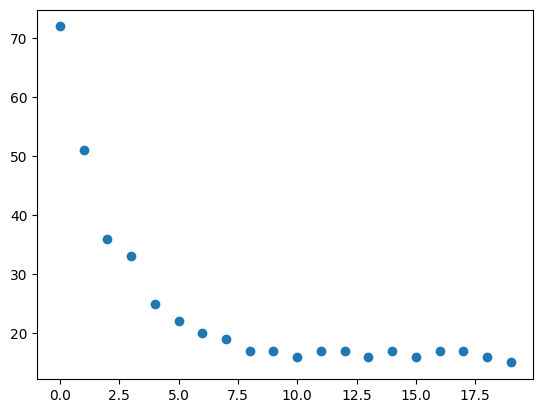

In [31]:
y_list = [len(l) for l in list_wrong_sg]
plt.scatter(np.arange(len(list_wrong_sg)), y_list)

Now, if we create the =.in for these groups, it also works.

### Analysis of the test

In [40]:
def error_percentage(file_log='log_failed_SGs.dat', list_ignore=[]):
    
    f = open(file_log, 'r')
    list_failed = []  # all that failed, including cifs with incorrect SG
    list_count = []  # failed, excluding cifs with incorrect SG
    for line in f:
        list_failed.append(int(line))    
        if int(line) not in list_ignore:
            list_count.append(int(line))
    num_tested = 230 - len(list_ignore)
    num_failed = len(list_count)
    num_success = num_tested - num_failed
    print(f'# SGs tested: {num_tested}')
    print(f'# Successfull: {num_success}')
    print(f'# Error: {num_failed}')
    print(f'Success rate: {num_success / num_tested * 100} %')
    print(f'Failed SGs:')
    for sg in list_failed:
        if sg in list_count:
            print(f'{sg}  x')
        else:
            print(f'{sg}')

In [44]:
list_wrong_sg[-1]

[45, 93, 110, 120, 143, 144, 145, 158, 169, 170, 171, 172, 179, 196, 203]

In [45]:
error_percentage(list_ignore=[])

# SGs tested: 230
# Successfull: 123
# Error: 107
Success rate: 53.47826086956522 %
Failed SGs:
1  x
2  x
6  x
7  x
8  x
9  x
21  x
25  x
26  x
27  x
28  x
29  x
30  x
31  x
32  x
33  x
34  x
35  x
36  x
38  x
39  x
40  x
41  x
42  x
43  x
44  x
45  x
46  x
64  x
65  x
66  x
67  x
68  x
79  x
80  x
81  x
82  x
87  x
88  x
93  x
97  x
98  x
107  x
108  x
109  x
110  x
111  x
112  x
113  x
114  x
115  x
116  x
117  x
118  x
119  x
120  x
121  x
122  x
139  x
140  x
141  x
142  x
143  x
144  x
145  x
146  x
147  x
148  x
149  x
150  x
151  x
152  x
153  x
154  x
155  x
156  x
157  x
158  x
159  x
160  x
161  x
162  x
163  x
164  x
165  x
166  x
167  x
168  x
169  x
170  x
171  x
172  x
174  x
179  x
187  x
188  x
189  x
190  x
196  x
203  x
207  x
215  x
216  x
217  x
218  x
219  x
220  x


In [ ]:
pick_materials(list_sg=[45], ind_material=2)
failed, wrong_sg = convert_cifs_to_ins(list_sg=list_failed[-1]+list_wrong_sg[-1])